In [1]:
%matplotlib inline

In [2]:
import glob
import os
# import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50,ResNet152,vgg19
from tensorflow.keras.models import Model,model_from_json
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_digits

In [3]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices()[1],True)

# _Brain Magnetic Resonance Imaging_

[Sourse:](https://c4.wallpaperflare.com/wallpaper/150/128/926/minimalism-people-brain-x-rays-wallpaper-preview.jpg)![](https://c4.wallpaperflare.com/wallpaper/150/128/926/minimalism-people-brain-x-rays-wallpaper-preview.jpg)

### 1. Goal ###

Предвиждане от снимките дали има рак или не (1 - има рак 0 - няма)

### 2. Abstract ###

Изкуствения интелект не е достигнал до такова ниво в момента че да лекува в буквалния смисъл на думата пациента или да казва какво трябва да се случва с него. Но е достатъчно добър да даде насоки и дори да покаже някакви области от снимката където лекарят да обърне внимание. 

Когато един модел му се махнат bias-ите той става много по функционален 

### _Table of Contents_
1. [Goal](#1.-Goal)
2. [Abstract](#2.-Abstract)
3. [Introduction](#3.-Introduction)
4. [About Our Data](#4.-About-Our-Data)
5. [Data Reading And Preprocessing](#5.-Data-Reading-And-Preprocessing)
6. [Models](#6.-Models)

### 3. Introduction ###

When abnormal cells develop within the brain, a tumor is created. Malignant tumors and benign (non-cancerous) tumors are the two primary categories of tumors. These can also be divided into primary tumors, which originate inside the brain, and secondary tumors, which typically spread from cancers outside the brain and are referred to as brain metastasis tumors. Depending on the tumor's size and the section of the brain it affects, all forms of brain tumors may cause a variety of symptoms. Where symptoms are present, they may include vomiting, headaches, seizures, eyesight issues, and mental changes. Other signs could include inability to talk or walk, feelings, or unconsciousness.

Without the use of radioactive tracers or ionizing radiation (X-rays), magnetic resonance imaging (MRI) of the brain employs magnetic resonance imaging to create high-quality two-dimensional or three-dimensional pictures of the brain, brainstem, and cerebellum.

[Source:](https://health.ucdavis.edu/radiology/images/MYMRI%20ICONS/MR%20Neuro/Joe%20Photos/brainpatient840.jpg)![](https://health.ucdavis.edu/radiology/images/MYMRI%20ICONS/MR%20Neuro/Joe%20Photos/brainpatient840.jpg)

### 4. About Our Data  ###

MRI Data is from [Kaggle](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).

In [4]:
my_file = open("archive/lgg-mri-segmentation/kaggle_3m/README.md", "r")
print(my_file.read())

# LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders na

### 5. Data Reading And Preprocessing ###

Тъй като имам 8 рам и си мисля че да заредя ~ 4000 снимки няма да ми стигне паметта затова ще направим pandas dataframe който ще ни пази всички пътища къде се намира снимката на дадения пациент и полсе ще я четем от дадения път. Знаем че всяка една снимка си има своя 'mask' която много ни улеснява работата защото просто ще заместим накрая стринга с '_mask.tif'. 

In [5]:
pat = "archive/lgg-mri-segmentation/kaggle_3m/"

In [6]:
id_patient = []
mapped_data = {}
for x in os.listdir(pat):
    if "." in x:
        continue
    for y in os.listdir(os.path.join(pat, x)):
        if y.endswith("_mask.tif"):
            continue
        brain_path = os.path.join(pat, x) + "/" + os.path.join(y)
        brain_mask_path = brain_path.replace(".tif", "_mask.tif")
        mapped_data.update({brain_path: brain_mask_path})
        # id_patient.append(x)

In [7]:
brain_data = pd.DataFrame(
    {
        # "pacient_id": id_patient,
        "image_of_pacient": mapped_data.keys(),
        "masks": mapped_data.values(),
    }
)

In [8]:
brain_data

,image_of_pacient,masks
0,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
1,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
2,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
3,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
4,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
...,...,...
3924,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...
3925,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...
3926,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...
3927,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...


Изглежда добре нека сега да се пробваме да прочетем някоя снимка която и да е тя за да видим дали работи правилно. Също нещо много важно дадения индекс на снимката на пациента отговия номер на маската му. 

In [9]:
brain_data.masks[8], brain_data.image_of_pacient[8]

('archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif')

изглежда че работи. Е нека да я видим в крайна сметка тук сме да гледаме мозъци а не стрингове xD 

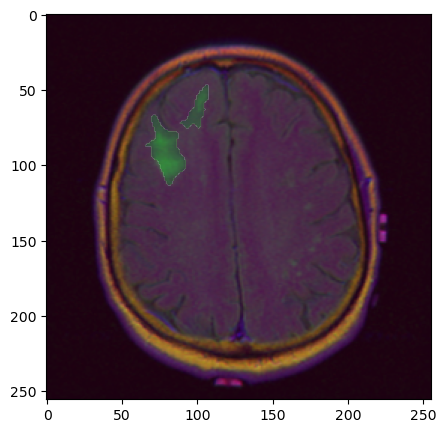

In [10]:
plt.figure(figsize=(5, 5))
img = io.imread(brain_data.image_of_pacient[8])
plt.imshow(img)
# plt.show()
plt.imshow(io.imread(brain_data.masks[8]), alpha=0.2, cmap="PiYG") # за по хубаво очертаване на рака 
plt.show()

Нека да направим колона която ни подксазва коя снимка на пациента има рак и коя не като снимката с рака ще е равна на 1 в противен случай 0 за да видим разпределението на снимките на нашите данни а и после ще ни трябва за 'ImageDataGenerator' - a

In [ ]:
brain_data["have_mask_or_not"] = brain_data.masks.apply(
    lambda x: 0 if np.max(io.imread(x)) == 0 else 1
)

In [ ]:
sns.countplot(x=brain_data.have_mask_or_not)
plt.ylabel("Count")
plt.title('Distribution of masks')
plt.xlabel('0 - no mask, 1 - have mask')
plt.show()

от сега може да имаме проблем скрит bias в самите данни може да е това има повече снимки без рак отколкото с такъв което ще окаже влияние на нашия модел

In [13]:
brain_data.have_mask_or_not = brain_data.have_mask_or_not.astype(str)

1. _Training Dataset_: a subset of data that was utilized to fit the model..

2. _Validation Dataset_: the subset of data used to assess a model's fit to a training dataset while adjusting model hyperparameters. As skill from the validation dataset is included into the model setup, the evaluation gets increasingly skewed.
3. _Test Dataset_: the subset of data that was used to impartially assess how well a final model fit the training dataset.

Сплитваме данните за да може да ги подадем на 'ImageDataGenerator'. С него ще ги разделим на train, val and test data. 

In [14]:
train, test = train_test_split(brain_data, test_size=0.3)

In [15]:
train.shape, test.shape

((2750, 3), (1179, 3))

I regularly encounter weird situations when utilizing deep learning models when there isn't enough data to train the model. These were the situations that inspired me to learn about picture enhancement.One excellent option to increase the amount of your dataset is to use the picture augmentation technique. However, a lot of users modify images in a conservative manner, by adding text and putting the results in a folder or a numpy array. I must admit that before discovering the ImageDataGenerator class, I used to do this. Each training image can have any random alteration applied to it when it is sent to the model. This will increase the sturdiness of your model and reduce overhead memory use. Image augmentation is a technique that modifies the original image in numerous ways to produce several altered copies of the same image. Nevertheless, depending on the augmentation techniques you choose, such as shifting, rotating, flipping, etc., each replica differs from the others in a few crucial ways.

In [43]:
preprocessed_brain_images = ImageDataGenerator(rescale=1/ 255., validation_split=0.1)

In [44]:
training_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="training",
    class_mode="categorical",
    batch_size=2,
    shuffle=True,
    target_size=(256, 256),
    
)

valid_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="validation",
    class_mode="categorical",
    batch_size=2,
    shuffle=True,
    target_size=(256,256),
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validated_data_generator = test_datagen.flow_from_dataframe(
    test,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    class_mode="categorical",
    batch_size=2,
    shuffle=False,
    target_size=(256, 256),
)

Found 2475 validated image filenames belonging to 2 classes.
Found 275 validated image filenames belonging to 2 classes.
Found 1179 validated image filenames belonging to 2 classes.


Нека да видим няколко снимки какво е направил "ImageDataGenerator"-а

(2, 256, 256, 3)


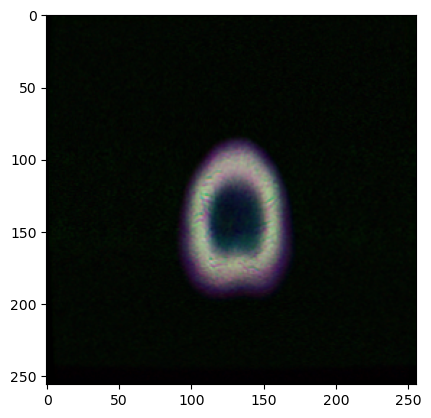

(2, 256, 256, 3)


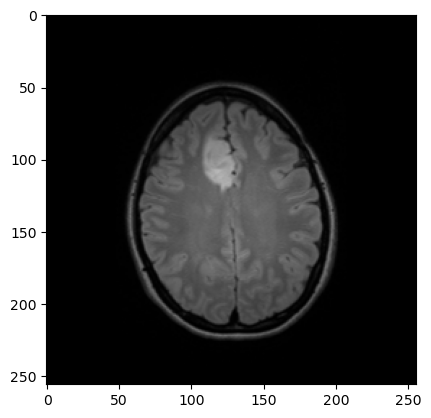

(2, 256, 256, 3)


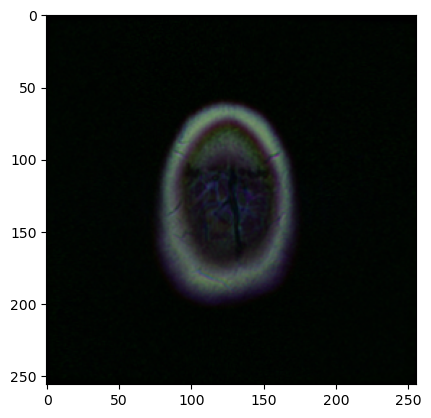

(2, 256, 256, 3)


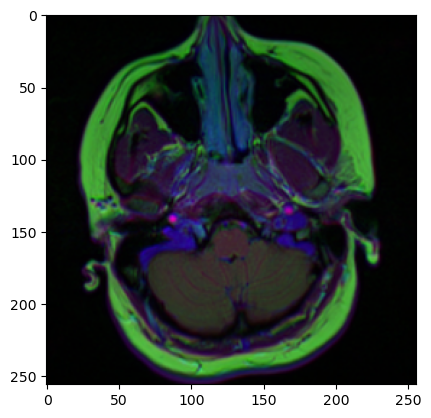

(2, 256, 256, 3)


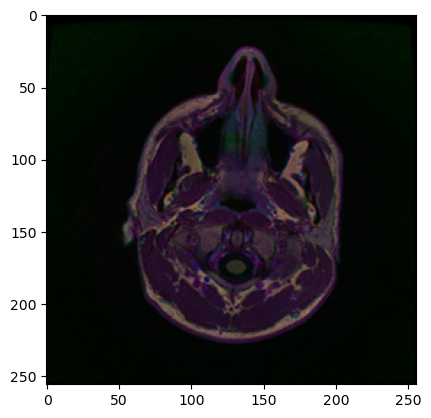

In [45]:
for _ in range(10,15):
    img, label = training_data_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### 6. Models ###

[Source:](https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png)![](https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png)

ResNet refers to the Residual Network, a specific type of convolutional neural network (CNN). CNNs are commonly used in computer vision applications. ResNet-50 is the name of a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks (RNNs) are artificial neural networks (ANNs) that construct networks using residual blocks. The ResNet architecture adheres to two key design tenets. First, there are the same number of filters in each layer regardless of the output feature map's size. Second, it has twice as many filters in order to preserve the temporal complexity of each layer even if the size of the feature map is reduced by half.

In the 50-layer ResNet, the bottleneck construction block is utilized. A bottleneck residual block uses 11 convolutions to reduce the number of parameters and matrix multiplications, and is frequently referred to as a "bottleneck". This greatly accelerates the training of each layer. It makes use of three layers as opposed to a stack with two levels.

In [49]:
resnet_model = ResNet50(input_shape=(244,244,3), weights='imagenet', include_top=False)
# resnet_model.summary() #от тук можем да видим модела

In [50]:
for layer in resnet_model.layers:
    layer.trainable = False #"freezing" the layer: Training only top layers the layers which we have added in the end

In [51]:
head = resnet_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(resnet_model.input, head)
model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary() #от тук можем да видим модела с добавените от нас layers

In [32]:
 # model.summary()

In [ ]:
first_model = model.fit(training_data_generator, 
              epochs = 50, 
              validation_data= valid_data_generator,)
                       # callbacks=EarlyStopping(monitor='val_loss', 
                       #        mode='min', 
                       #        verbose=1, 
                       #        patience=15))


Epoch 1/50
1238/1238 [==============================] - 45s 33ms/step - loss: 0.6881 - accuracy: 0.6412 - val_loss: 0.6382 - val_accuracy: 0.6655
Epoch 2/50
  69/1238 [>.............................] - ETA: 34s - loss: 0.6548 - accuracy: 0.6377

In [ ]:
aa

След като тренирахме модела нека да видим как се е справил ще запазим него и неговите стойности за да не ги изгубим

In [ ]:
# !mkdir -p saved_model

In [ ]:
# model_stat=pd.Series({"loss":first_model.history['loss'],
#                       'val_loss':first_model.history['val_loss'],
#                       'accuracy':first_model.history['accuracy'],
#                       'val_accuracy':first_model.history['val_accuracy']
#                      })

In [ ]:
# model_stat.to_pickle("my_data.pkl")

In [ ]:
model_stat = pd.read_pickle("my_data.pkl")

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_stat.loss);
plt.plot(model_stat.val_loss);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(model_stat.accuracy);
plt.plot(model_stat.val_accuracy);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

Лосса намалява като цяло а за валидационния сет е доста назъбен(ходи много нагоре надолу) но намаля а до колкото оценката на модела много не мърда за трениращите данни а за валидационния пак е много назъбен това ми подсказва че самия модел трябва да се променят layer ите по някакъв начин за да се вдигне оценката на модела

In [ ]:
# model.save('saved_model/my_model')

In [ ]:
model_loaded = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
_, acc = model_loaded.evaluate(validated_data_generator)
print(f"Test accuracy : {acc*100} %")

добра оценка има модела 

In [ ]:
prediction = model_loaded.predict(validated_data_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['have_mask_or_not']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

$${\displaystyle F_{1} score ={\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}=2{\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}={\frac {2\mathrm {tp} }{2\mathrm {tp} +\mathrm {fp} +\mathrm {fn} }}}$$

$${\displaystyle {\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}}}$$

Precision - Out of all the examples the model obtained, the number of relevant instances.

Recall - The proportion of all relevant instances that the model correctly identified as relevant.

не се учудвам че precision на '1' е 0.62 има много доста повече снимки без рак отколкото без такъв и това както се вижда се отрази и на модела вкарахме му bias. 

нека да видим как ще предвиди модела снимките

In [ ]:
# make prediction
test_predict = model_loaded.predict(validated_data_generator)

# Obtain the predicted class from the model prediction
predict_resnet50 = []
for i in test_predict:
  predict_resnet50.append(str(np.argmax(i)))
predict_resnet50 = np.asarray(predict_resnet50)

In [ ]:
predict_resnet50

In [ ]:
# for _ in range(650,660):
#     img = validated_data_generator.filepaths[_]
#     plt.imshow(io.imread(img))
#     plt.title(predict_resnet50[_])
#     plt.show()
#     plt.imshow(io.imread(img[2:-4]+'_mask.tif'))
#     plt.title('actual mask')
#     plt.show()

както се вижда наистина не предвижда снимките с рак много добре но пък тези които са без рак се вижда че ги предвижда по добре. от 10 снимки 7 ги е предвидило правилно. 6 снимки които са без рак ги е предвидило правилно 1 не е успяло и от три снимки които имат рак е предвидило 1. 

ResNet152 е като ResNet50 разликата е в големината на модела

In [ ]:
resnet152_model = ResNet152(input_shape=(224,224,3), weights='imagenet', include_top=False)
# resnet152_model.summary()

In [ ]:
for layer in resnet152_model.layers:
    layer.trainable = False

In [ ]:
head = resnet152_model.output

head = AveragePooling2D(pool_size=(4,4))(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='sigmoid')(head)
head = Flatten(name='Flatten')(head)


model = Model(resnet152_model.input, head)
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resnet_152_weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

In [ ]:
second_model = model.fit(training_data_generator, 
              epochs = 50, 
              validation_data= valid_data_generator,)
#                        callbacks=[earlystopping,checkpointer])

In [ ]:
# !mkdir -p saved_model_resnet_152

In [ ]:
# model_stat=pd.Series({"loss":second_model.history['loss'],
#                       'val_loss':second_model.history['val_loss'],
#                       'accuracy':second_model.history['accuracy'],
#                       'val_accuracy':second_model.history['val_accuracy']
#                      })

In [ ]:
# model_stat.to_pickle("my_data_resnet_152.pkl")

In [ ]:
model_stat_resnet_152 = pd.read_pickle("my_data_resnet_152.pkl")

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_stat_resnet_152.loss);
plt.plot(model_stat_resnet_152.val_loss);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(model_stat_resnet_152.accuracy);
plt.plot(model_stat_resnet_152.val_accuracy);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

повече ми харесват тези резултати от resnet50 лос функцията е по ниска и за трайн сет и за валидационния сет и имаме по голяма оценка също на модела някакси двете криви повече се доближават от тези на resnet50. Нека да видим дали е по добър в деяствителност докато не тестваме няма как да разберем.

In [ ]:
# model.save('saved_model_resnet_152/my_model_resnet_152')

In [ ]:
model_resnet_152_loaded = tf.keras.models.load_model('saved_model_resnet_152/my_model_resnet_152')

In [ ]:
model_resnet_152_loaded.load_weights('resnet_152_weights.hdf5')

In [ ]:
_, acc = model_resnet_152_loaded.evaluate(validated_data_generator)
print(f"Test accuracy : {acc*100} %")

In [ ]:
prediction = model_resnet_152_loaded.predict(validated_data_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['have_mask_or_not']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

интересно мислех че модела ще е по добър от предишния а се оказа обратното получихме по малка оценка и още по ниски стойности за сниките които имат рак но много близки стойности на тези които имат рак.

нека да видим как ще предвиди тестовите данни

In [ ]:
test_predict = model_resnet_152_loaded.predict(validated_data_generator)

# Obtain the predicted class from the model prediction
predict_resnet152 = []
for i in test_predict:
  predict_resnet152.append(str(np.argmax(i)))
predict_resnet152 = np.asarray(predict_resnet152)

In [ ]:
predict_resnet152

In [ ]:
# for _ in range(650,660):
#     img = validated_data_generator.filepaths[_]
#     plt.imshow(io.imread(img))
#     plt.title(f'{predict_resnet152[_]} - resnet152')
#     plt.show()
#     plt.imshow(io.imread(img))
#     plt.title(f'{predict_resnet50[_]} - resnet50')
#     plt.show()
#     plt.imshow(io.imread(img[2:-4]+'_mask.tif'))
#     plt.title('actual mask')
#     plt.show()

от 7 снимки без рак моделът е сгрешил 1 а 3 снимки с рак е сгрешило 2

[Source](https://wikidocs.net/images/page/164796/vgg_Fig_01.png)![](https://wikidocs.net/images/page/164796/vgg_Fig_01.png)

The concept of the VGG19 model (also VGGNet-19) is the same as the VGG16 except that it supports 19 layers. The “16” and “19” stand for the number of weight layers in the model (convolutional layers). This means that VGG19 has three more convolutional layers than VGG16. We’ll discuss more on the characteristics of VGG16 and VGG19 networks in the latter part of this article.

In [ ]:
vgg19_model = vgg19.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
# vgg19_model.summary()

In [ ]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
head = vgg19_model.output

head = AveragePooling2D(pool_size=(4,4))(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='sigmoid')(head)
head = Flatten(name='Flatten')(head)


model = Model(vgg19_model.input, head)
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="VGG_19_weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

In [ ]:
# second_model = model.fit(training_data_generator, 
#               # steps_per_epoch= len(training_data_generator), 
#               epochs = 50, 
#               validation_data= valid_data_generator,
#                        callbacks=[earlystopping,checkpointer])

In [ ]:
# !mkdir -p vgg19_model

In [ ]:
# model_stat=pd.Series({"loss":second_model.history['loss'],
#                       'val_loss':second_model.history['val_loss'],
#                       'accuracy':second_model.history['accuracy'],
#                       'val_accuracy':second_model.history['val_accuracy']
#                      })

In [ ]:
# model_stat.to_pickle("my_data_vgg19.pkl")

In [ ]:
model_stat_vgg19 = pd.read_pickle("my_data_vgg19.pkl")

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_stat_vgg19.loss);
plt.plot(model_stat_vgg19.val_loss);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(model_stat_vgg19.accuracy);
plt.plot(model_stat_vgg19.val_accuracy);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

странно поведение на лос функцията на валидатион сета качва се но на трениращите данни спада. оценката на трениращите данни постоянно се качва а до валидатион сета изглежда все едно се е качила и в един момент е спряло.

In [ ]:
# model.save('vgg19_model/my_model_vgg19')

In [ ]:
model_vgg19_loaded = tf.keras.models.load_model('vgg19_model/my_model_vgg19')

In [ ]:
model_vgg19_loaded.load_weights('VGG_19_weights.hdf5')

In [ ]:
_, acc = model_vgg19_loaded.evaluate(validated_data_generator)
print(f"Test accuracy : {acc*100} %")

In [ ]:
prediction = model_vgg19_loaded.predict(validated_data_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['have_mask_or_not']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

изглежда че много добре се справя моделът

In [ ]:
test_predict = model_vgg19_loaded.predict(validated_data_generator)

# Obtain the predicted class from the model prediction
predict_vgg19 = []
for i in test_predict:
  predict_vgg19.append(str(np.argmax(i)))
predict_vgg19 = np.asarray(predict_vgg19)

In [ ]:
for _ in range(650,660):
#     fig = plt.figure(figsize=(20,10))
#     fig.add_subplot(2,2,1)
    
    img = validated_data_generator.filepaths[_]
    

    plt.imshow(io.imread(img))
    plt.axis('off')
    plt.title(f'{predict_resnet50[_]} - resnet50')
    plt.show()
    
    plt.imshow(io.imread(img))
    plt.axis('off')
    plt.title(f'{predict_resnet152[_]} - resnet152')
    plt.show()
    
    plt.imshow(io.imread(img))
    plt.axis('off')
    plt.title(f'{predict_vgg19[_]} - vgg19')
    plt.show()
    
    plt.axis('off')
    plt.imshow(io.imread(img[2:-4]+'_mask.tif'))
    plt.title('actual mask')
    plt.show()

най добрия модел от трита е vgg19 тъй като позна най много снимки интересно е как някои модели предвиждат правилно а други не в различните ситуации както и бъркат в различните ситуации в друг сценарии всички се справят добре в друг всички бъркат по скоро е интересно не къде предвиждат всички или къде бъркат всики по интересно защо се дъни 

нека да пробваме да видим всъщност защо vgg19 се справя по добре като първо му сложим повече тестови данни и по малко трениращи 

In [ ]:
# model_vgg19_loaded.summary()

In [ ]:
train, test = train_test_split(brain_data, test_size=0.15)

In [ ]:
preprocessed_brain_images = ImageDataGenerator(rescale=1./ 244., validation_split=0.1)

In [ ]:
training_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="training",
    class_mode="categorical",
    batch_size=4,
    shuffle=True,
    target_size=(224, 224),
    
)

valid_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="validation",
    class_mode="categorical",
    batch_size=4,
    shuffle=True,
    target_size=(224,224),
)
test_datagen = ImageDataGenerator(rescale=1.0 / 244.0)
validated_data_generator = test_datagen.flow_from_dataframe(
    test,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    class_mode="categorical",
    batch_size=4,
    shuffle=False,
    target_size=(224, 224),
)

In [ ]:
vgg19_model = vgg19.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
# vgg19_model.summary()

In [ ]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
head = vgg19_model.output

head = AveragePooling2D(pool_size=(4,4))(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='sigmoid')(head)
head = Flatten(name='Flatten')(head)


model = Model(vgg19_model.input, head)
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="VGG_19_weights_with_more_samples.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

In [ ]:
# second_model = model.fit(training_data_generator, 
#               # steps_per_epoch= len(training_data_generator), 
#               epochs = 50, 
#               validation_data= valid_data_generator,
#                        callbacks=[earlystopping,checkpointer])

In [ ]:
# model_stat=pd.Series({"loss":second_model.history['loss'],
#                       'val_loss':second_model.history['val_loss'],
#                       'accuracy':second_model.history['accuracy'],
#                       'val_accuracy':second_model.history['val_accuracy']
#                      })

In [ ]:
# model_stat.to_pickle("my_data_vgg19_with_more_samples.pkl")

In [ ]:
model_stat_vgg19_with_more_samples = pd.read_pickle("my_data_vgg19_with_more_samples.pkl")

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_stat_vgg19_with_more_samples.loss);
plt.plot(model_stat_vgg19_with_more_samples.val_loss);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(model_stat_vgg19_with_more_samples.accuracy);
plt.plot(model_stat_vgg19_with_more_samples.val_accuracy);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

по интересното е че валидайшън лоса е по ниско и трайнинг сета е по ниско модела има по висока оценка очаквано

In [ ]:
# !mkdir -p vgg19_model_with_more_samples

In [ ]:
# model.save('vgg19_model_with_more_samples/my_model_vgg19_with_more_samples')

In [ ]:
model_vgg19_loaded_with_more_samples = tf.keras.models.load_model('vgg19_model_with_more_samples/my_model_vgg19_with_more_samples')

In [ ]:
model_vgg19_loaded_with_more_samples.load_weights('VGG_19_weights_with_more_samples.hdf5')

In [ ]:
prediction = model_vgg19_loaded_with_more_samples.predict(validated_data_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['have_mask_or_not']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

очаквано

In [ ]:
test_predict = model_vgg19_loaded_with_more_samples.predict(validated_data_generator)

# Obtain the predicted class from the model prediction
vgg19_with_more_samples = []
for i in test_predict:
  vgg19_with_more_samples.append(str(np.argmax(i)))
vgg19_with_more_samples = np.asarray(vgg19_with_more_samples)

In [ ]:
# for _ in range(10,20):
#     # if int(predict[_]) == 1:
#     img = validated_data_generator.filepaths[_]
#     plt.imshow(io.imread(img))
#     plt.title(vgg19_with_more_samples[_])
#     plt.show()
#     plt.imshow(io.imread(img[2:-4]+'_mask.tif'))
#     plt.title('actual mask')
#     plt.show()

има огромна вероятно да оверфитва в момента тъй като модела има прекалено малко тестови данни

нека да пробваме да махнем скрития баяс в данните като ги направим равни снимките който имат рак с тези които нямат

In [ ]:
brain_data.have_mask_or_not.value_counts()

In [ ]:
brain_data.have_mask_or_not=brain_data.have_mask_or_not.astype(int)

In [ ]:
a=brain_data[brain_data.have_mask_or_not == 0][:1373]

In [ ]:
b=brain_data[brain_data.have_mask_or_not == 1]

In [ ]:
a=a.reset_index()

In [ ]:
b=b.reset_index()

In [ ]:
brain_data=pd.concat([a,b])

In [ ]:
brain_data=brain_data[brain_data.columns[1:]]

In [ ]:
brain_data.have_mask_or_not.value_counts()

In [ ]:
brain_data.have_mask_or_not = brain_data.have_mask_or_not.astype(str)

In [ ]:
train, test = train_test_split(brain_data, test_size=0.3)

In [ ]:
preprocessed_brain_images = ImageDataGenerator(rescale=1./ 244., validation_split=0.1)

In [ ]:
training_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="training",
    class_mode="categorical",
    batch_size=4,
    shuffle=True,
    target_size=(224, 224),
    
)

valid_data_generator = preprocessed_brain_images.flow_from_dataframe(
    train,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    subset="validation",
    class_mode="categorical",
    batch_size=4,
    shuffle=True,
    target_size=(224,224),
)
test_datagen = ImageDataGenerator(rescale=1.0 / 244.0)
validated_data_generator = test_datagen.flow_from_dataframe(
    test,
    directory="./",
    x_col="image_of_pacient",
    y_col="have_mask_or_not",
    class_mode="categorical",
    batch_size=4,
    shuffle=False,
    target_size=(224, 224),
)

In [ ]:
vgg19_model = vgg19.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
# vgg19_model.summary()

In [ ]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
head = vgg19_model.output

head = AveragePooling2D(pool_size=(4,4))(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='sigmoid')(head)
head = Flatten(name='Flatten')(head)


model = Model(vgg19_model.input, head)
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="VGG_19_weights_with_balance_data.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

In [ ]:
# second_model = model.fit(training_data_generator, 
              # epochs = 50, 
              # validation_data= valid_data_generator,
              #          callbacks=[earlystopping,checkpointer])

In [ ]:
# model_stat=pd.Series({"loss":second_model.history['loss'],
#                       'val_loss':second_model.history['val_loss'],
#                       'accuracy':second_model.history['accuracy'],
#                       'val_accuracy':second_model.history['val_accuracy']
#                      })

In [ ]:
# model_stat.to_pickle("my_data_vgg19_with_balance_data.pkl")

In [ ]:
my_data_vgg19_with_balance_data = pd.read_pickle("my_data_vgg19_with_balance_data.pkl")

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(my_data_vgg19_with_balance_data.loss);
plt.plot(my_data_vgg19_with_balance_data.val_loss);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(my_data_vgg19_with_balance_data.accuracy);
plt.plot(my_data_vgg19_with_balance_data.val_accuracy);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
# !mkdir -p vgg19_with_balance_data

In [ ]:
# model.save('vgg19_with_balance_data/my_model_vgg19_with_balance_data')

In [ ]:
model_vgg19_loaded_with_balance_data = tf.keras.models.load_model('vgg19_with_balance_data/my_model_vgg19_with_balance_data')

In [ ]:
model_vgg19_loaded_with_balance_data.load_weights('VGG_19_weights_with_balance_data.hdf5')

In [ ]:
prediction = model_vgg19_loaded_with_balance_data.predict(validated_data_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['have_mask_or_not']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

уха това е много висока оценка 

нека да видим как ще ги предвижда

In [ ]:
test_predict = model_vgg19_loaded_with_balance_data.predict(validated_data_generator)

# Obtain the predicted class from the model prediction
vgg19_with_balance_data = []
for i in test_predict:
  vgg19_with_balance_data.append(str(np.argmax(i)))
vgg19_with_balance_data = np.asarray(vgg19_with_balance_data)

In [ ]:
for _ in range(10,20):
    # if int(predict[_]) == 1:
    img = validated_data_generator.filepaths[_]
    
    plt.imshow(io.imread(img))
    plt.axis('off')
    plt.title(f'{predict_vgg19[_]} - vgg19')
    plt.show()
    
    plt.imshow(io.imread(img))
    plt.title(f'{vgg19_with_balance_data[_]} - vgg19 with balance data')
    plt.show()
    
    plt.imshow(io.imread(img))
    plt.title(f'{vgg19_with_more_samples[_]} - vgg19 with more samples')
    plt.show()
    
    plt.imshow(io.imread(img[2:-4]+'_mask.tif'))
    plt.title('actual mask')
    plt.show()
    print('===============')

всеки един модел се дъни на определени места от другите и предсказва там къдете другите не го правят но по интересното е че моделът 'vgg19 with balance data' предвижда най много от трита и имаше най висока оценка след това идва моделът 'vgg19' които също е много добър но малко по малко от 'vgg19 with balance data' и последен е 'vgg19 with more samples'. Очаквах модела 'vgg19 with more samples' да предвижда най много а то се оказа че предвижда най малко :д.